# Handling LEFTfield chains with 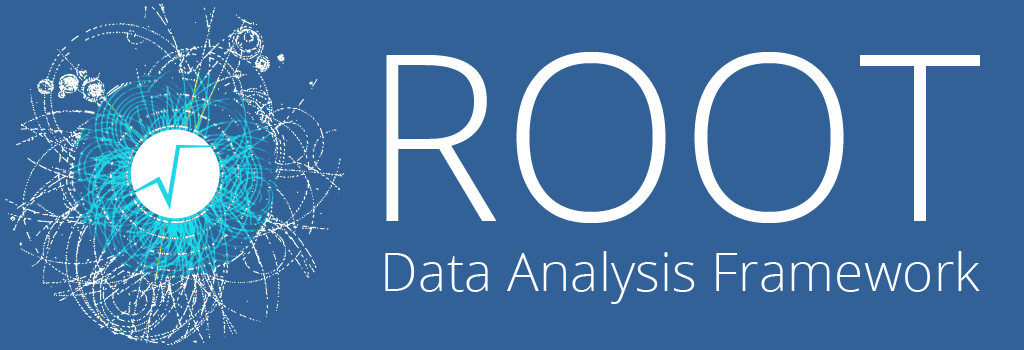

This is a tutorial of how to handle [LEFTfield](https://gitlab.mpcdf.mpg.de/leftfield/release/leftfield) chain output with [pyROOT](https://root.cern/manual/python/), from `.root` files to `getdist.MCSamples`.

For [Jupyter](https://jupyter.org/) `.ipynb` examples of how to handle chain output in `.hdf5` format, follow [this URL](https://gitlab.mpcdf.mpg.de/leftfield/leftfield_devel/-/tree/minh/dask_example/jupyter_notebook_examples) instead.

## Required modules

In [1]:
import ROOT
import os, glob
from itertools import chain
from pathlib import Path
import numpy as np

from getdist import MCSamples,loadMCSamples,plots

Welcome to JupyROOT 6.28/00


In [7]:
import matplotlib
matplotlib.style.use('Minh_paper_style') # comment this out or adapt to your style file
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import (FixedLocator, MultipleLocator, ScalarFormatter, FixedFormatter, FormatStrFormatter,
                               AutoMinorLocator)
plt.rcParams.update({
    "text.usetex": False,
    "font.sans-serif": "Fira Sans",
    'text.latex.preamble': r'\usepackage{cmbright}',  # Choose a font package if desired
})
plt.rcParams['figure.dpi'] = 300

## Data path & key

Adapt the path below to your path.

In [ ]:
z_snaps=['0.0','0.5','1.0']
chain_paths=['/freya/ptmp/mpa/fabians/SNG/HMC/production/ada/lM12.5-14.0_z'+z_snap+'_NUFFT256' for z_snap in z_snaps]
Lambda_values=['0.12','0.14']
kmax_values=['0.10','0.12']
NGeul_values=['96','116']
chain_names=[f"TPIretestL{Lambda}kmax{kmax}_2LPT3D-NUFFT_fourierlike_NGeul{NGeul}_cubesphereNGlike63_sigmalim_" for Lambda,kmax,NGeul in zip(Lambda_values,kmax_values,NGeul_values)]
chain_list=[os.path.join(chain_path,chain_name) for chain_path in chain_paths for chain_name in chain_names]

## Handlers

In [2]:
class ROOTChainHandler:
    r"""
    Chain handler to sort and combine multiple chain batches into a list.
    that each chain contains >=1 batches and each batch is stored in a ``.root`` file.
    """
    def __init__(self, chain_path, single_chain=True):
        self.chain_path = chain_path
        self.chain_batches = []
        self.single_chain = single_chain
        
    def find_and_sort_chain_batches(self,batch_path):
        r"""
        Find and sort all batches in numerical ascending order
        """
        path = Path(os.path.split(batch_path)[0])
        self.chain_batches.append(sorted(path.glob(os.path.split(batch_path)[1]+'[0-9]*.root'),\
            key=lambda p: int(p.stem.rsplit(os.path.split(batch_path)[1], 1)[1])))
        self.chain_batches = list(chain.from_iterable(self.chain_batches))
    
    def process_files(self):
        r"""
        Process batches matching the input path+batch_prefix
        """
        if self.single_chain is True:
            try:
                self.find_and_sort_chain_batches(self.chain_path)
            except TypeError as err:
                raise TypeError("If `single_chain=True`, ``chain_path`` must be a 'str', not a 'list'.") from err
        else:
            for path in self.chain_path:
                self.find_and_sort_chain_batches(path)

    def get_batch(self):
        r"""
        Return path+names of batches matching the input path+batch_prefix, sorted in numerical ascending order
        """
        if not self.chain_batches:
            self.process_files()
        return self.chain_batches

class ROOTFileHandler:
    r"""
    File handler to extract parameters from a single ``.root`` file
    """
    def __init__(self, file_name, tree_name):
        self.file_name = file_name
        self.tree_name = tree_name
        self.file = None
        self.tree = None
        self.branches = []
        self.branch_leaves = []
        self.leaf_values = []
        self.leaf_weights = None

    def process_file(self):
        r"""
        Process the ``.root`` file
        """
        self.open_file()
        self.traverse_tree()
        self.close_file()
    
    def open_file(self):
        if self.file_name:
            self.file = ROOT.TFile.Open(self.file_name, "READ")

    def close_file(self):
        r"""
        Close the ``.root`` file
        """
        if self.file:
            self.file.Close()

    def traverse_tree(self):
        r"""
        Open the ``.root`` file, traverse the tree and retrieve branches plus leaves.
        The leaves are stored as ``numpy.ndarray`` of shape `[Nparams,Nsamples]`
        """
        if self.file is None:
            try:
                self.open_file()
            except FileNotFoundError as err:
                raise FileNotFoundError("Cannot open ``.root`` file. Check chain path.") from err
        else:
            key = self.file.GetKey(self.tree_name)
            if key:
                self.tree = key.ReadObj()
                branches = self.tree.GetListOfBranches()

                for branch in branches:
                    branch_name = branch.GetName()
                    leaves = []
                    leaf_values_branch = []
                    self.branches.append(branch_name)
                    self.branch_leaves.append(leaves)

                    branch_ptr = self.tree.GetBranch(branch_name)
                    leaf_count = branch_ptr.GetListOfLeaves().GetEntries()

                    for i in range(leaf_count):
                        leaf = branch_ptr.GetLeaf(branch_ptr.GetListOfLeaves().At(i).GetName())
                        leaf_name = leaf.GetName()
                        leaves.append(leaf_name)
                        leaf_values_branch.append(np.zeros(self.tree.GetEntries()))

                        for entry in range(self.tree.GetEntries()):
                            self.tree.GetEntry(entry)
                            branch_ptr.GetEntry(entry)
                            leaf_value = leaf.GetValue()
                            leaf_values_branch[i][entry]=leaf_value
                            
                    self.leaf_values.append(leaf_values_branch)
                    
                self.leaf_values = np.array(self.leaf_values)
            else:
                print("Key not found.")

    def show_branch(self):
        r"""
        Display names of 'branch' in 'root' tree
        """
        print("List of branches:")
        for b, branch in enumerate(self.branches):
            print(f"Branch {b + 1}: {branch}")

    def get_branch_list(self):
        r"""
        Get list of 'branch' in 'root' tree
        """
        if not self.branches:
            self.process_file()
        return self.branches

    def show_leaf(self):
        r"""
        Display names and values of 'leaf' in 'root' tree
        """
        print("List of leaves:")
        for l, leaf in enumerate(self.branch_leaves):
            print(f"Leaf {l + 1}: {leaf}")
        if self.leaf_values.size > 0:
            print("\nShape of leaves as a Numpy array:")
            print(self.leaf_values.shape)
            print("\nValues stored in leaves:")
            print(self.leaf_values)
        else:
            print("No value found in leaves.")

    def get_leaf_list(self):
        r"""
        Get list of 'leaf' in 'root' tree
        """
        if not self.branch_leaves:
            self.process_file()
        return self.branch_leaves

    def get_leaf_value(self):
        r"""
        Get values of 'leaf' in 'root' tree
        """
        if not self.leaf_values:
            self.process_file()
        return self.leaf_values

class ChainPacker:
    r"""
    Chain packer to pack sample parameters into a GetDist MCSamples object
    """
    def __init__(self,param_labels,param_values,chain_settings=None,sample_weights=None):
        self.weighted_samples = None
        self.param_values = param_values
        self.chain_settings = chain_settings
        self.sample_weights = sample_weights
        self.param_latex_labels = []
        self.param_labels = param_labels
        if (len(self.param_labels) != self.param_values[2:,:].shape[0]):
            raise IndexError("Number of parameters and number of parameter labels do not match.")
        self.latex_label_dict = {
            'alpha': r'\alpha',
            'b1': r'b_\delta',
            'b_lapldelta': r'b_{\nabla^2 \delta}',
            'b_lapldelta2': r'b_{\nabla^2 \delta^2}',
            'b_laplK2': r'b_{\nabla^2 K^2}',
            'b_lapl_lapldelta': r'b_{\nabla^4 \delta}',
            'b_sigmasigma': r'b_{(\mathrm{tr}[M^{(1)}])^2}',
            'b_sigmasigmasigma': r'b_{(\mathrm{tr}[M^{(1)}])^3}',
            'b_sigmatrM1M1': r'b_{\mathrm{tr}[(M^{(1)})^2]\mathrm{tr}[M^{(1)}]}',
            'b_trM1M1M1': r'b_{\mathrm{tr}[(M^{(1)})^3]}',
            'b_trM1M1' : r'b_{\mathrm{tr}[(M^{(1)})^2]',
            'b_trM1M2' : r'b_{\mathrm{tr}[M^{(1)}M^{(2)}]}',
            'b_K2' : r'b_{K^2}',
            'b_K3' : r'b_{K^3}',
            'b_Otd' : r'b_{\mathrm{Otd}}',
            'bd2' : r'b_{\delta^2}',
            'b_delta2' : r'b_{\delta^2}',
            'b_deltaK2' : r'b_{\delta K^2}',
            'b_delta3' : r'b_{\delta^3}',
            'sigma' : r'\sigma_\epsilon',
            'sigmaEpsk2' : r'\sigma_{\epsilon_{k^2}}',
            'sigmaEpsk4' : r'\sigma_{\epsilon_{k^4}}'
}
        for label in self.param_labels:
            if label not in self.latex_label_dict:
                raise KeyError(f"Parameter label '{label}' cannot be found in the latex label 'dict'.")

    def get_param_latex_labels(self):
        r"""
        Look up latex labels in the 'dict'
        """
        if len(self.param_latex_labels) > 0:
            self.param_latex_labels = []
        for label in self.param_labels:
            self.param_latex_labels.append(self.latex_label_dict[label])

    def get_MCSamples(self):
        r"""
        Pack the ``numpy.ndarray`` of sample parameters, of shape `[Nparams,Nsamples]`, into ``getdist.MCSamples`` object
        """
        if len(self.param_latex_labels) == 0:
            self.get_param_latex_labels()
        return MCSamples(samples=self.param_values[2:,:].T,\
                         names=self.param_labels,labels=self.param_latex_labels,\
                         weights=self.sample_weights,loglikes=self.param_values[1,:],\
                         settings=self.chain_settings)

## Examples

We first load and sort chain batches.

In [3]:
chain_list=['/cobra/ptmp/minh/lefty_challenge/flatLCDM/box1/sampling_bO_shat/Eulerian_NUFFT/twolptthird_nufft/chain2a_Epsk2Epsk4_sigma010/sampling_bO_shat_2lptsecond_nufft_FOURIER_NGEul1024_L0.14_cube.stage3_']
chain_handler = ROOTChainHandler(chain_list[0],single_chain=True)

Now we load the chain and extract parameter values from its samples.

In [4]:
chain_batches=chain_handler.get_batch()
param_values=[]
tree_name='bias'
for c in chain_batches:
    file_handler = ROOTFileHandler(str(c), tree_name) #TFile.Open only accepts input ``filename`` as 'str'
    param_values.append(file_handler.get_leaf_value())
param_values = np.concatenate(param_values, axis=-1).squeeze()
print("Number of parameters:")
print(param_values.shape[0])
print("Number of samples:")
print(param_values.shape[1])

Number of parameters:
14
Number of samples:
134300


Error in <TList::Clear>: A list is accessing an object (0x5631ff801490) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x5631ff7db780) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x5631ff7e33e0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x5631ff7e3750) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x5631ff7e3ac0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x5631ff7e3ff0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x5631ff7e4470) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x5631ff873de0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x5631ff87b460) already deleted (list name = TList)
Error in <TList::Clear>: A l

We also need the list of parameters. Currently, they can be accessed through either `ROOTFileHandler.get_branch_list()` or `ROOTFileHandler.get_leaf_list()`.

In [5]:
param_name_list=file_handler.get_branch_list()
print(param_name_list)
param_name_list=param_name_list[2:]
print(param_name_list)

['s', 'logL', 'alpha', 'b_K2', 'b_K3', 'b_Otd', 'b1', 'b_deltaK2', 'bd2', 'b_delta3', 'b_lapldelta', 'sigma', 'sigmaEpsk2', 'sigmaEpsk4']
['alpha', 'b_K2', 'b_K3', 'b_Otd', 'b1', 'b_deltaK2', 'bd2', 'b_delta3', 'b_lapldelta', 'sigma', 'sigmaEpsk2', 'sigmaEpsk4']


Next, we pack the chain samples into a `getdist.mcsamples` object.

In [6]:
default_getdist_settings = {'ignore_rows': '0.3', 'converge_test_limit': '0.95',\
                                 'smooth_scale_1D': '-1', 'smooth_scale_2D': '-1'}
universally_wide_KDE_settings = {'ignore_rows': '0.', 'converge_test_limit': '0.95',\
                                 'smooth_scale_1D': '0.5', 'smooth_scale_2D': '0.7'}

chain_samples=ChainPacker(param_name_list,param_values,chain_settings=universally_wide_KDE_settings)
getdist_MCSamples=chain_samples.get_MCSamples()

Removed no burn in


TypeError: 'ChainPacker' object is not subscriptable

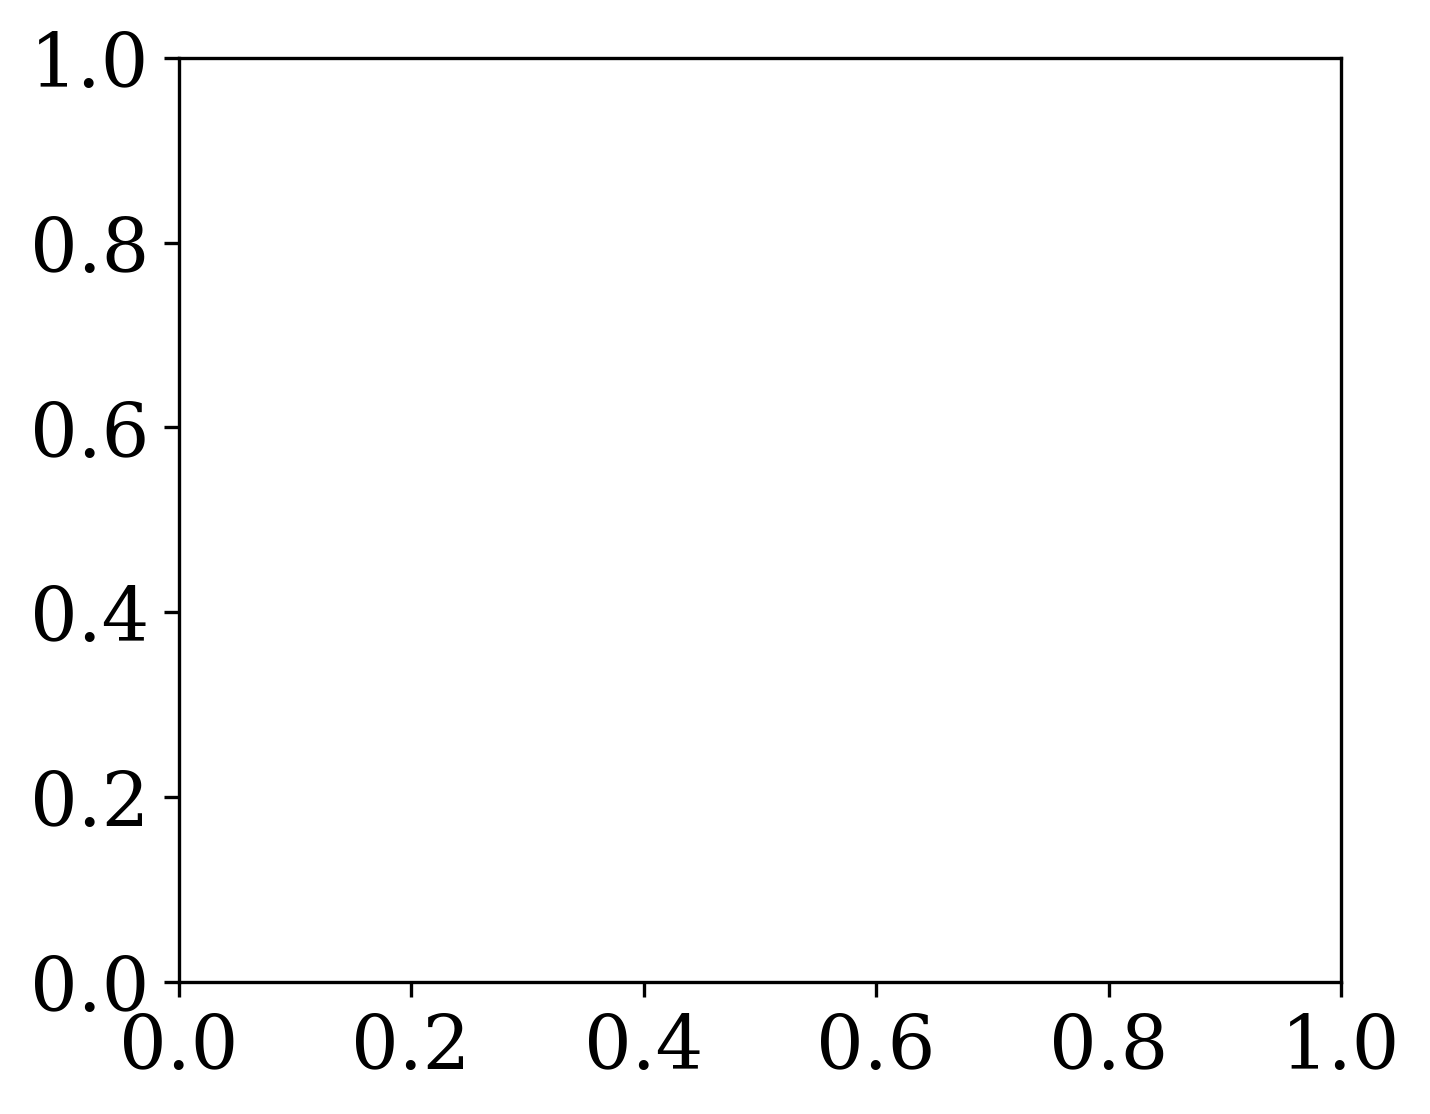

In [9]:
fig,ax=plt.subplots(nrows=1,ncols=1,sharex=False,sharey=True,figsize=(5,4),gridspec_kw={'hspace': 0.2, 'wspace': 0.})
ax.plot(np.arange(0,len(chain_samples['alpha'])),chain_samples['alpha'],c='slateblue',label=r'2LPTthird')
ax.axhline(y=1,ls='--',c='k',zorder=0)
ax.set_ylabel(r'$\alpha$')
ax.set_xlabel(r'samples')
ax.legend(frameon=False,loc='upper left',handlelength=1.5)
ax.text(0.4,0.15,r'$z=1.0$',transform=ax.transAxes)
ax.text(0.4,0.05,r'$k_{\mathrm{max}}=0.10h\mathrm{Mpc}^{-1}$',transform=ax.transAxes)

fig,ax=plt.subplots(nrows=1,ncols=1,sharex=False,sharey=True,figsize=(5,4),gridspec_kw={'hspace': 0.2, 'wspace': 0.})
ax.plot(np.arange(0,len(chain_samples['sigmaEff'])),chain_samples['sigmaEff'],c='slateblue',label=r'2LPTthird')
ax.axhline(y=0.1*0.9,ls='--',c='k',zorder=0)
ax.set_ylabel(r'$\sigma_{\mathrm{eff}}$')
ax.set_xlabel(r'samples')
ax.legend(frameon=False,loc='lower left',handlelength=1.5)
ax.text(0.4,0.85,r'$z=1.0$',transform=ax.transAxes)
ax.text(0.4,0.75,r'$k_{\mathrm{max}}=0.10h\mathrm{Mpc}^{-1}$',transform=ax.transAxes)

fig,ax=plt.subplots(nrows=1,ncols=1,sharex=False,sharey=True,figsize=(5,4),gridspec_kw={'hspace': 0.2, 'wspace': 0.})
ax.plot(np.arange(0,len(chain_samples['sigma'])),chain_samples['sigma'],c='slateblue',label=r'2LPTthird')
ax.axhline(y=0.1,ls='--',c='k',zorder=0)
ax.set_ylabel(r'$\sigma$')
ax.set_xlabel(r'samples')
ax.legend(frameon=False,loc='lower left',handlelength=1.5)
ax.text(0.4,0.85,r'$z=1.0$',transform=ax.transAxes)
ax.text(0.4,0.75,r'$k_{\mathrm{max}}=0.10h\mathrm{Mpc}^{-1}$',transform=ax.transAxes)

fig,ax=plt.subplots(nrows=1,ncols=1,sharex=False,sharey=True,figsize=(5,4),gridspec_kw={'hspace': 0.2, 'wspace': 0.})
ax.plot(np.arange(0,len(chain_samples['sigmaEpsk2'])),chain_samples['sigmaEpsk2'],c='slateblue',label=r'2LPTthird')
ax.axhline(y=-32.,ls='--',c='k',zorder=0)
ax.axhline(y=32.,ls='--',c='k',zorder=0)
ax.set_ylabel(r'$\sigma_{\epsilon,k^2}$')
ax.set_xlabel(r'samples')
ax.legend(frameon=False,loc='lower left',handlelength=1.5)
ax.text(0.4,0.85,r'$z=1.0$',transform=ax.transAxes)
ax.text(0.4,0.75,r'$k_{\mathrm{max}}=0.10h\mathrm{Mpc}^{-1}$',transform=ax.transAxes)

In [ ]:
import classy
from classy import Class
import numpy as np
import pandas as pd

#pivot scale + redshift
z_p = 1.0
k_p = 0.2 #our pivot scale, in h/Mpc units

#settings to configure CLASS computations
settings = {
    'output': 'mPk', #which quantities we want CLASS to compute
    'z_pk' : z_p,
    'non linear' : 'none',
    
    'P_k_max_1/Mpc':1.0 # CLASS uses 1/Mpc units
}

Finally, we can analyze the chains with `getdist`.

In [14]:
g = plots.get_subplot_plotter()
g.triangle_plot(getdist_MCSamples, filled=True)

NameError: name 'FBI_sample_list' is not defined

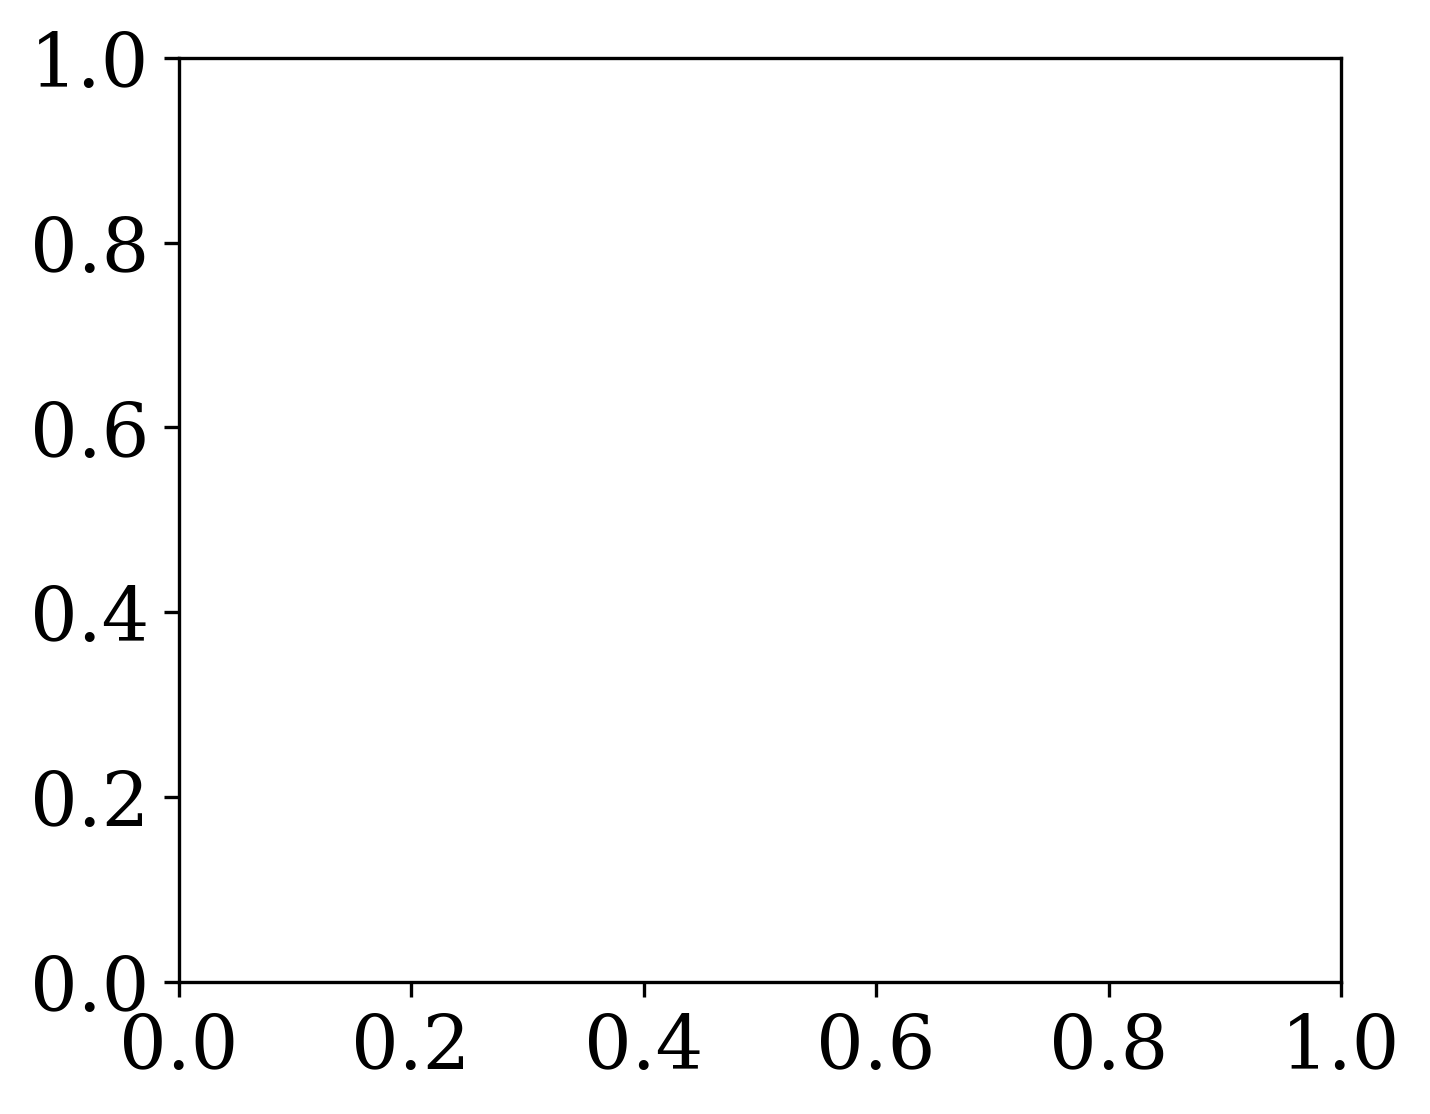

In [16]:
fig,ax=plt.subplots(nrows=1,ncols=1,sharex=False,sharey=True,figsize=(5,4),gridspec_kw={'hspace': 0.2, 'wspace': 0.})
ax.plot(np.arange(0,len(getdist_MCSamples['alpha'])),getdist_MCSamples['alpha'],c='slateblue',label=r'TPI')
ax.axhline(y=1,ls='--',c='k',zorder=0)
ax.set_ylabel(r'$\alpha$')
ax.set_xlabel(r'samples')
ax.legend(frameon=False,loc='upper left',handlelength=1.5)
ax.text(0.4,0.15,r'$z=1.0$',transform=ax.transAxes)
ax.text(0.4,0.05,r'$k_{\mathrm{max}}=0.10h\mathrm{Mpc}^{-1}$',transform=ax.transAxes)

fig,ax=plt.subplots(nrows=1,ncols=1,sharex=False,sharey=True,figsize=(5,4),gridspec_kw={'hspace': 0.2, 'wspace': 0.})
ax.plot(np.arange(0,len(getdist_MCSamples['sigmaEff'])),getdist_MCSamples['sigmaEff'],c='slateblue',label=r'TPI')
ax.axhline(y=0.12,ls='--',c='k',zorder=0)
ax.set_ylabel(r'$\sigma_{\mathrm{eff}}$')
ax.set_xlabel(r'samples')
ax.legend(frameon=False,loc='lower left',handlelength=1.5)
ax.text(0.4,0.85,r'$z=1.0$',transform=ax.transAxes)
ax.text(0.4,0.75,r'$k_{\mathrm{max}}=0.10h\mathrm{Mpc}^{-1}$',transform=ax.transAxes)